In [1]:
class Value:
  def __init__(self, data, _children=()): #children is the set of things that we tell it (v1, v2...)
    self.data = data
    self.grad = 0 
    self._backward = lambda: None #helps calculate derivative
    self._prev = set(_children)  #stores value for all children

In [2]:
def backward(self, visited=None):
  if visited is None: #if this is the first time we are starting the backwards process
    visited = set([self])
    self.grad = 1 #partial derivative of the loss with respect to the loss
  self._backward() 
  for child in self._prev: 
    if not child in visited: # if the child has not been visited so far
      visited.add(child) #add child to the visited
      child.backward(visited)

Value.backward = backward #backward pass

In [11]:
import random
import math

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data = None, _children=(), _op=''):
        if data is None:
          data = random.uniform(-1,1)
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
    
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()


    # Arithmetic operations 

    def __add__(self, other): # forward pass
        other = other if isinstance(other, Value) else Value(other) #turning into instance
        out = Value(self.data + other.data, (self, other)) #create output

        def _backward():
            # out = other + self
            # d out / d self = d self / d self = 1
            # d L / d self = d L / d out * d out / d self = d L / d out = out.grad    out is v1,v2,v3
            self.grad += out.grad 
            other.grad += out.grad
        out._backward = _backward

        return out

    Value.__add__ = __add__ #adding method to Value instance

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other))

        def _backward():
            # out = other * self
            # d out / d self = other * d self / delf = other
            # d L / d self = d L / d out * d out / d self = out.grad * other
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    Value.__mul__ = __mul__ #multiplying method to Value self

# In first reading you can ignore all code below here - if you understand everything above then you undestand the main concepts        
##############################################################################################################################

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
      # out = relu(self) = 0 if self is negative and self otherwise
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU') #change here for sigmoid

        def _backward():
          # out = relu(self)
          # d out / d self = 0 if data is negative and 1 otherwise
            self.grad += (out.data > 0) * out.grad #change here for sigmoid
        out._backward = _backward

        return out

    def sigmoid(self):

      out = Value(1/(1 + math.e**(-self.data)), (self,), 'Sigmoid')

      def _backward():
        self.grad += (math.e**(-self.data)/(1 + math.e**(-self.data))**2) * out.grad

      out._backward = _backward

      return out

    # Other operations implemented in terms of prior ones 
    def __float__(self): return float(self.data)
    def __neg__(self): return self * -1
    def __radd__(self, other): return self + other
    def __sub__(self, other):  return self + (-other)
    def __rsub__(self, other): return other + (-self)
    def __rmul__(self, other): return self * other
    def __truediv__(self, other): return self * other**-1
    def __rtruediv__(self, other): return other * self**-1
    def __repr__(self): return f"Value(data={self.data}, grad={self.grad})"

In [12]:
class Linear:
  def __init__(self): #initialization
    self.a,self.b = Value(0),Value(0)
  def __call__(self,x):
    return self.a*x+self.b #x is slope, b is intercept
  def zero_grad(self):
    self.a.grad, self.b.grad = 0,0

def loss(y,y_): # We'll use the standard l_2 loss
  return (y-y_)**2 # Is it okay that we're not multiplying by 1/2?

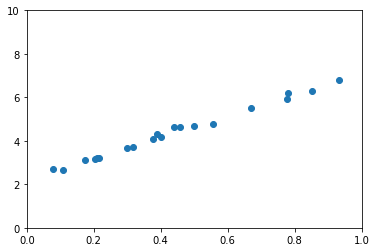

In [13]:
import matplotlib.pyplot as plt
n = 20
X = [random.random() for i in range(n)]
Y = [5*x + 2 + 0.5*random.random() for x in X]
plt.scatter(X, Y)
plt.xlim(0,1)
plt.ylim(0,10)
plt.show()

In [20]:
from IPython.display import clear_output
def plot_line(X, Y, model, pause_time=1):
  clear_output()
  x_values_plotting = [0,1]
  y_values_plotting = [model.a * x + model.b for x in x_values_plotting]
  plt.plot(x_values_plotting, y_values_plotting, color='red')
  plt.scatter(X, Y)
  plt.xlim(0,1)
  plt.ylim(0,10)
  plt.show()
  time.sleep(pause_time)  

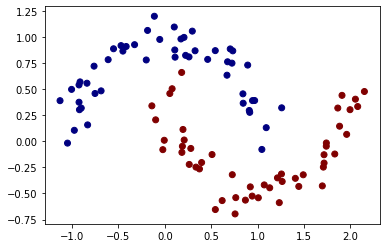

In [21]:
from sklearn.datasets import make_moons, make_blobs
X, Y = make_moons(n_samples=100, noise=0.1) #noise is some unwanted variability in the data
Y = 2*Y - 1 # go from {0,1} to {-1, 1} #convenient way to change step into sigmoid

plt.scatter(X[:,0],X[:,1], c=Y, cmap='jet')
plt.show()

In [22]:
def neuron(weights, inputs, sigmoid=True):  #make sigmoid = True
  v = sum(w*x for w,x in zip(weights, inputs)) #zip pairs inputs with weights
  return v.sigmoid() if sigmoid else v #returns value if positive, 0 if not # make sigmoid

class Net:
  # The list comprehension is fancy but this is exactly the architecture
  # we've been drawing in class.
  def __init__(self, hidden_dim=16):
    self.layer_1 = [[Value(), Value()] for i in range(hidden_dim)]
    self.layer_2 = [[Value() for j in range(hidden_dim)] for i in range(hidden_dim)] #inner layer, next layer?
    self.output = [Value() for i in range(hidden_dim)] #to a single value
    self.parameters = [v for L in [self.layer_1,self.layer_2,[self.output]] for w in L for v in w]
  
  def __call__(self, x): 
    layer_1_vals = [neuron(w,x) for w in self.layer_1] #computes neuron values
    layer_2_vals = [neuron(w, layer_1_vals) for w in self.layer_2]
    return neuron(self.output, layer_2_vals, sigmoid=False) #final activation, relu is false we want a negative value
  
  def zero_grad(self):
    for p in self.parameters:
      p.grad = 0

In [23]:
import numpy as np

def plot_prediction(X, Y, model, title=None, h=.5):
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
  Xmesh = np.c_[xx.ravel(), yy.ravel()]
  inputs = [list(map(Value, xrow)) for xrow in Xmesh]
  scores = list(map(model, inputs))
  Z = np.array([s.data > 0 for s in scores])
  Z = Z.reshape(xx.shape)
  
  fig = plt.figure()
  clear_output()
  if title != None: plt.title(title)
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
  plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  plt.show()

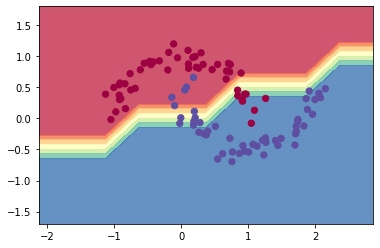

In [24]:
model = Net(20) 

num_epochs = 30
learning_rate = 1
for epoch in range(num_epochs): 
  loss = 0
  for x,y in zip(X,Y): 
    output = model(x)
    # want y*output = 1
    # set lowest loss at 0
    loss += (1 + -y*output).relu() #.relu() means it can never be below 0
  loss = loss/len(X) # normalize
  model.zero_grad() #zero out gradient so we dont accumulate too much
  loss.backward()
  for p in model.parameters:
    p.data -= learning_rate * p.grad   
  accuracy = sum(float(model(x))*y > 0 for x,y in zip(X,Y))/len(X)  
  message = f'Epoch: {epoch}, Loss: {round(loss.data, 2)},  Accuracy: {accuracy*100}'
  print(message)
  plot_prediction(X, Y, model)

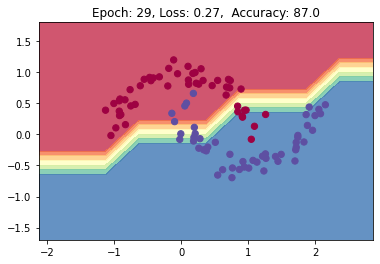

In [25]:
plot_prediction(X, Y, model, title=message, h=.5)